# Estrategia de Promedio Movil de 40

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from yahoofinancials import YahooFinancials
from datetime import date, timedelta
from scipy.signal import argrelextrema
from statsmodels.nonparametric.kernel_regression import KernelReg
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from scipy import stats

In [3]:
ini = date.today() - timedelta(days=1460) # 4 years ago
ini2 = date.today() - timedelta(days=728) # 2 years ago
today = date.today()
ini_str = str(ini)
ini2_str = str(ini2)
today_str = str(today)
print(ini_str)
print(ini2_str)
print(today_str)
tickers = [
'TSLA',
'SPY'
]

2020-10-06
2022-10-08
2024-10-05


In [5]:
yahoo_financials = YahooFinancials (tickers)
historical_stock_prices = yahoo_financials.get_historical_price_data(ini_str, today_str, 'daily')

In [6]:
index = 1
df_d = pd.DataFrame()
for ticker in tickers:
    index+=1
    tupla = pd.DataFrame(historical_stock_prices[ticker]['prices'])
    tupla['companyName']=ticker
    tupla['SMA20'] = tupla['close'].rolling(20).mean()
    tupla.dropna(inplace=False)
    tupla['SMA40'] = tupla['close'].rolling(40).mean()
    tupla.dropna(inplace=False)
    tupla['SMA100'] = tupla['close'].rolling(100).mean()
    tupla.dropna(inplace=False)
    tupla['SMA200'] = tupla['close'].rolling(200).mean()
    tupla.dropna(inplace=False)
    if index==1:
        df_d = tupla
    else:
        df_d = pd.concat([df_d, tupla], ignore_index=True)
df_d = df_d.drop('date',axis=1)
df_d.rename(columns={"formatted_date": "date"}, inplace = True)
df_d['date']=pd.to_datetime(df_d['date'])

In [43]:
##descarga de dataframe HORA
df_h = pd.DataFrame()
for ticker in tickers:
    company = yf.download(ticker, start = ini2_str, end = today_str, interval='60m')
    ##company = pd.read_csv("https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol="+ticker+"&interval=60min&month=2024-09&outputsize=full&datatype=csv&apikey=NC6PCMYOFPL8LYVC")
    ##company = pd.read_csv("https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol=ticker&interval=daily&month=2023-10&outputsize=full&apikey=NC6PCMYOFPL8LYVC&datatype=csv")
    ## cambio de nombre de las columnas
    ##print (company)
    company.rename(columns={'Datetime':'datetime','Open':'open','High':'high','Low':'low','Close':'close','Adj Close':'adj close','Volume':'volume'}, inplace = True)
    
    company['date'] = pd.to_datetime (company.index.date)
    company['datetime'] = pd.to_datetime (company.index)    
    company['companyName'] = ticker
    company['SMA20'] = company['close'].rolling(20).mean()
    company.dropna(inplace=False)
    company['SMA40'] = company['close'].rolling(40).mean()
    company.dropna(inplace=False)
    company['SMA100'] = company['close'].rolling(100).mean()
    company.dropna(inplace=False)
    company['SMA200'] = company['close'].rolling(200).mean()
    company.dropna(inplace=False)
    
    df_h = pd.concat([df_h, company],ignore_index=True)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [13]:
## Funcion minimos y maximos por HORA

def find_extrema_h(s, col, bw='cv_ls'):
    """
    Input:
        s: prices as pd.series
        bw: bandwith as str or array like
    Returns:
        prices: with 0-based index as pd.series
        extrema: extrema of prices as pd.series
        smoothed_prices: smoothed prices using kernel regression as pd.series
        smoothed_extrema: extrema of smoothed_prices as pd.series
    """
    # Copy series so we can replace index and perform non-parametric
    # kernel regression.
    prices = s.copy()
    prices = prices.reset_index()
    
    #print(prices.head(5))
    prices.columns = ['index','datetime',col]
    
    #prices.columns = ['date', 'close', 'date2']
    horas = prices['datetime']
    prices = prices[col]    
    
    #prices = s.copy()
    #prices.columns = ['date', 'price']
    #prices = pd.DataFrame(s)
    #prices = prices['close']
    
    #print(type(prices))
    #print("===============")
    #print(prices)
    #print("===============")
    #print(prices.index)

    kr = KernelReg(
        [prices.values],
        [prices.index.to_numpy()],
        var_type='c', bw=bw
    )
    f = kr.fit([prices.index.values])

    # Use smoothed prices to determine local minima and maxima
    smooth_prices = pd.Series(data=f[0], index=prices.index)
    smooth_local_max = argrelextrema(smooth_prices.values, np.greater)[0]
    smooth_local_min = argrelextrema(smooth_prices.values, np.less)[0]
    local_max_min = np.sort(
        np.concatenate([smooth_local_max, smooth_local_min]))
    smooth_extrema = smooth_prices.loc[local_max_min]

    # Iterate over extrema arrays returning datetime of passed
    # prices array. Uses idxmax and idxmin to window for local extrema.
    price_local_max_dt = []
    for i in smooth_local_max:
        if (i > 1) and (i < len(prices)-1):
            price_local_max_dt.append(prices.iloc[i-2:i+2].idxmax())

    price_local_min_dt = []
    for i in smooth_local_min:
        if (i > 1) and (i < len(prices)-1):
            price_local_min_dt.append(prices.iloc[i-2:i+2].idxmin())

    maxima = pd.Series(prices.loc[price_local_max_dt])
    minima = pd.Series(prices.loc[price_local_min_dt])
    extrema = pd.concat([maxima, minima]).sort_index()
  

    # Return series for each with bar as index
    return extrema, prices, smooth_extrema, smooth_prices, maxima, minima, horas

In [15]:
# Determinar puntos minimos por HORA
df_h2 = df_h
index = 1
df_min = pd.DataFrame()
df_max = pd.DataFrame()
for ticker in tickers:
    print(ticker)
    print(index)
    index+=1
    tuplas = df_h2.query("companyName==@ticker")
    #col1 = 'close'
    
    colmin='low'
    tuplas2 = tuplas[['datetime',colmin]]   
    extrema, prices, smooth_extrema, smooth_prices, maxima, minima, horas = find_extrema_h(tuplas2, colmin, bw=[1.5])
    
    minima2 = minima.to_frame()
    minima2 = minima2.drop_duplicates()
    minima2.rename(columns={"low": "trendlower"}, inplace = True)
    minima2['companyName']=ticker    
    #minima2 = minima2.reset_index()
    minima2 = pd.concat([minima2, horas], join = 'outer', axis=1)
    
    colmax='high'
    tuplas3 = tuplas[['datetime',colmax]]
    extrema, prices, smooth_extrema, smooth_prices, maxima, minima, horas = find_extrema_h(tuplas3, colmax, bw=[1.5])

    maxima2 = maxima.to_frame()
    maxima2 = maxima2.drop_duplicates()
    maxima2.rename(columns={"high": "trendhigher"}, inplace = True)
    maxima2['companyName']=ticker
    #maxima2 = maxima2.reset_index()
    maxima2 = pd.concat([maxima2, horas], join = 'outer', axis=1)
    
    if index==1:        
        df_min = minima2
        df_max = maxima2
    else:
        df_min = pd.concat([df_min, minima2],ignore_index=True)
        df_max = pd.concat([df_max, maxima2],ignore_index=True)
    #del tuplas, tuplas2, extrema, prices, smooth_extrema, smooth_prices, maxima, minima, minima2, maxima2


#print(df_min.head(5))
#print(df_max.head(5))
df_h2 = pd.merge(df_h2, df_min[['datetime','companyName', 'trendlower']], on = ['companyName','datetime'], how='left')
df_h2 = pd.merge(df_h2, df_max[['datetime','companyName', 'trendhigher']], on = ['companyName','datetime'], how='left')

TSLA
1
SPY
2


In [17]:
maxima2.query("index==2430")

,trendhigher,companyName,datetime
2430,NaN,NaN,2024-02-13 15:30:00


In [19]:
#puntos de cambio de tendencia cuando close_min es mayor a cero
#punto de cambio a tendencia alcista
def pm01(df_h2):
    if ((df_h2['trendlower']>0) & ((df_h2['low']-df_h2['SMA40'])<=0.5)):
        return 1
    else:
        return 0
df_h2['pm40_01'] = df_h2.apply(pm01, axis=1)

In [21]:
#el PM20 sobre el PM40, el PM40 por encima del PM100 y este ultimo por encima del PM200
def pm02(df_h2):
    if (((df_h2['SMA20'] - df_h2['SMA40'])>1) & (df_h2['SMA40'] > df_h2['SMA100']) & (df_h2['SMA100'] > df_h2['SMA200'])):
        return 1
    else:
        return 0
df_h2['ind_SMA'] = df_h2.apply(pm02, axis=1)

#numeracion de casos donde se dio el cambio de tendencia
df_h2['id_posiblepm40'] = df_h2.query("pm40_01==1 and ind_SMA==1").groupby(["companyName"]).cumcount()+1

In [23]:
df_h2['id_posiblepm40'].drop_duplicates()

0        NaN
675      1.0
705      2.0
1165     3.0
1298     4.0
1305     5.0
1373     6.0
2053     7.0
2081     8.0
2178     9.0
2215    10.0
2503    11.0
2508    12.0
2919    13.0
3021    14.0
3044    15.0
3141    16.0
3420    17.0
3456    18.0
3468    19.0
5700    20.0
5913    21.0
5939    22.0
5983    23.0
6012    24.0
6017    25.0
6034    26.0
6482    27.0
6535    28.0
Name: id_posiblepm40, dtype: float64

In [25]:
df_h2.query("pm40_01==1 and ind_SMA==1 and companyName=='TSLA'")
#df_h2

,open,high,low,close,adj close,volume,date,datetime,companyName,SMA20,SMA40,SMA100,SMA200,trendlower,trendhigher,pm40_01,ind_SMA,id_posiblepm40
675,194.414993,194.979996,187.610001,191.844498,191.844498,53966991,2023-02-13,2023-02-13 09:30:00,TSLA,202.217251,198.169710,179.698654,150.663555,187.610001,NaN,1,1,1.0
705,198.470001,202.850006,197.500000,200.856094,200.856094,29009574,2023-02-17,2023-02-17 11:30:00,TSLA,209.302025,203.560683,194.671338,164.743588,197.500000,NaN,1,1,2.0
1165,182.229996,182.940002,178.220001,178.660004,178.660004,42319156,2023-05-24,2023-05-24 09:30:00,TSLA,184.974940,179.226105,172.436717,170.485757,178.220001,NaN,1,1,3.0
1298,250.770004,261.700012,248.250000,261.575012,261.575012,57186742,2023-06-22,2023-06-22 09:30:00,TSLA,264.548653,260.953999,240.852020,210.653287,248.250000,NaN,1,1,4.0
1305,259.290009,262.019989,252.800003,254.740005,254.740005,49167611,2023-06-23,2023-06-23 09:30:00,TSLA,264.410021,261.482911,244.751585,213.892668,252.800003,NaN,1,1,5.0
1373,270.045013,270.850006,265.100006,267.119995,267.119995,18872228,2023-07-10,2023-07-10 11:30:00,TSLA,276.543623,271.783739,263.360830,243.551675,265.100006,NaN,1,1,6.0
2053,237.429993,237.500000,232.100006,234.190002,234.190002,35260133,2023-11-27,2023-11-27 09:30:00,TSLA,236.918961,235.863571,227.811884,223.386010,232.100006,NaN,1,1,7.0
2081,233.139999,236.330002,231.899994,233.255005,233.255005,37892650,2023-12-01,2023-12-01 09:30:00,TSLA,243.309466,239.522916,234.026688,223.106346,231.899994,NaN,1,1,8.0
2178,248.580002,249.460007,247.000000,247.239899,247.239899,12048781,2023-12-20,2023-12-20 15:30:00,TSLA,254.846040,251.048420,244.064906,238.729497,247.000000,NaN,1,1,9.0
2215,252.600006,252.710007,247.429993,248.020004,248.020004,21336449,2023-12-29,2023-12-29 10:30:00,TSLA,258.144554,255.769465,250.176290,244.451834,247.429993,NaN,1,1,10.0


In [27]:
df_h2.query('pm40_01==1')

,open,high,low,close,adj close,volume,date,datetime,companyName,SMA20,SMA40,SMA100,SMA200,trendlower,trendhigher,pm40_01,ind_SMA,id_posiblepm40
45,242.754593,243.910004,241.009995,243.059906,243.059906,8912170,2022-10-03,2022-10-03 12:30:00,TSLA,266.460592,273.572682,NaN,NaN,241.009995,NaN,1,0,NaN
58,234.169998,237.490005,233.270004,236.059998,236.059998,11309893,2022-10-05,2022-10-05 11:30:00,TSLA,248.184591,262.386665,NaN,NaN,233.270004,NaN,1,0,NaN
63,241.750000,244.580002,235.350006,235.850006,235.850006,21895705,2022-10-06,2022-10-06 09:30:00,TSLA,243.227396,256.872458,NaN,NaN,235.350006,244.580002,1,0,NaN
77,224.500000,226.990005,218.358200,225.380005,225.380005,24510024,2022-10-10,2022-10-10 09:30:00,TSLA,233.294157,241.601249,NaN,NaN,218.358200,226.990005,1,0,NaN
91,215.330002,217.490005,211.509995,213.229996,213.229996,21339710,2022-10-12,2022-10-12 09:30:00,TSLA,221.781864,230.507010,NaN,NaN,211.509995,NaN,1,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6883,552.530029,552.755005,549.510010,552.140015,552.140015,13159555,2024-09-03,2024-09-03 15:30:00,SPY,558.551752,559.326797,556.903233,546.502562,549.510010,NaN,1,0,NaN
6902,540.830017,541.049988,539.440002,539.989990,539.989990,3677853,2024-09-06,2024-09-06 13:30:00,SPY,548.303156,553.666704,556.949754,546.931496,539.440002,NaN,1,0,NaN
6910,544.960022,545.630005,544.179993,545.590027,545.590027,4449438,2024-09-09,2024-09-09 14:30:00,SPY,545.424896,550.331573,556.074352,546.920264,544.179993,NaN,1,0,NaN
6914,547.729980,547.729980,543.380005,544.289978,544.289978,4509060,2024-09-10,2024-09-10 11:30:00,SPY,544.823499,549.065575,555.581052,547.021575,543.380005,NaN,1,0,NaN


In [29]:
#obtener 20 datos anteriores y despues, dataframe HORA
df_h3 = pd.DataFrame()

posiciones = 20 #horas que entran en evaluacion por caso
mitad = int(posiciones/2)

for i, row in df_h2.iterrows():    
    print("index:" ,i, "company:", df_h2['companyName'][i])    
    if (df_h2['pm40_01'][i]==1):
        print("index insertar:",i)
        tupla = df_h2.query("index==@i")
        #tupla = df_h2.loc[i]
        tupla = tupla.reset_index(drop=True)
        tupla['ind_posicion']=0 #punto central
        #id_posiblepm40 = tupla["id_posiblepm40"].max()
        #tupla = df_d2.loc[i]
        if len(df_h3)<1:
            df_h3 = tupla
        else:
            df_h3 = pd.concat([df_h3, tupla],ignore_index=True)

        id_posiblepm40 = df_h2.loc[i, 'id_posiblepm40']
        print ("id_posiblepm40:", id_posiblepm40)

        filas_posteriores1 = df_h2.iloc[i+1: i + (mitad + 1)]
        filas_posteriores1 = filas_posteriores1.reset_index(drop=True)
        filas_posteriores1['pm40_01']=0
        filas_posteriores1['id_posiblepm40']=id_posiblepm40
        filas_posteriores1['ind_posicion']=1 #primera parte mitad de registros posteriores

        filas_posteriores2 = df_h2.iloc[i+mitad+1: i + (posiciones+1)]
        filas_posteriores2 = filas_posteriores2.reset_index(drop=True)
        filas_posteriores2['pm40_01']=0
        filas_posteriores2['id_posiblepm40']=id_posiblepm40
        filas_posteriores2['ind_posicion']=2 #segunda parte mitad de registros posteriores

        filas_anteriores1 = df_h2.iloc[max(0, i - posiciones):i-mitad]
        filas_anteriores1 = filas_anteriores1.reset_index(drop=True)
        filas_anteriores1['pm40_01']=0
        filas_anteriores1['id_posiblepm40']=id_posiblepm40
        filas_anteriores1['ind_posicion']=-2 #primera mitad de registros anteriores

        filas_anteriores2 = df_h2.iloc[max(0, i - mitad):i]
        filas_anteriores2 = filas_anteriores2.reset_index(drop=True)
        filas_anteriores2['pm40_01']=0
        filas_anteriores2['id_posiblepm40']=id_posiblepm40
        filas_anteriores2['ind_posicion']=-1 #segunda mitad de registros anteriores

        df_h3 = pd.concat([df_h3, filas_anteriores2],ignore_index=True)
        df_h3 = pd.concat([df_h3, filas_anteriores1],ignore_index=True)
        df_h3 = pd.concat([df_h3, filas_posteriores1],ignore_index=True)
        df_h3 = pd.concat([df_h3, filas_posteriores2],ignore_index=True)

    # Obtener las 10 filas anteriores desde la posición actual
    #df_company = df_d2.query('companyName==@companyName')
    

index: 0 company: TSLA
index: 1 company: TSLA
index: 2 company: TSLA
index: 3 company: TSLA
index: 4 company: TSLA
index: 5 company: TSLA
index: 6 company: TSLA
index: 7 company: TSLA
index: 8 company: TSLA
index: 9 company: TSLA
index: 10 company: TSLA
index: 11 company: TSLA
index: 12 company: TSLA
index: 13 company: TSLA
index: 14 company: TSLA
index: 15 company: TSLA
index: 16 company: TSLA
index: 17 company: TSLA
index: 18 company: TSLA
index: 19 company: TSLA
index: 20 company: TSLA
index: 21 company: TSLA
index: 22 company: TSLA
index: 23 company: TSLA
index: 24 company: TSLA
index: 25 company: TSLA
index: 26 company: TSLA
index: 27 company: TSLA
index: 28 company: TSLA
index: 29 company: TSLA
index: 30 company: TSLA
index: 31 company: TSLA
index: 32 company: TSLA
index: 33 company: TSLA
index: 34 company: TSLA
index: 35 company: TSLA
index: 36 company: TSLA
index: 37 company: TSLA
index: 38 company: TSLA
index: 39 company: TSLA
index: 40 company: TSLA
index: 41 company: TSLA
in

In [30]:
#df_h3[df_h3['open'].isna()]
df_h3[df_h3['id_posiblepm40'].isna()]
#df_h3.query("id_posiblepm40==1 and companyName=='AAPL'")

,open,high,low,close,adj close,volume,date,datetime,companyName,SMA20,SMA40,SMA100,SMA200,trendlower,trendhigher,pm40_01,ind_SMA,id_posiblepm40,ind_posicion
0,242.754593,243.910004,241.009995,243.059906,243.059906,8912170,2022-10-03,2022-10-03 12:30:00,TSLA,266.460592,273.572682,NaN,NaN,241.009995,NaN,1,0,NaN,0
1,265.299988,271.879608,262.470001,271.369995,271.369995,20533990,2022-09-30,2022-09-30 09:30:00,TSLA,277.709979,NaN,NaN,NaN,262.470001,NaN,0,0,NaN,-1
2,271.390015,275.570007,271.000000,274.399994,274.399994,10593260,2022-09-30,2022-09-30 10:30:00,TSLA,277.432629,NaN,NaN,NaN,NaN,275.570007,0,0,NaN,-1
3,274.429993,274.700012,269.130005,270.880005,270.880005,7874754,2022-09-30,2022-09-30 11:30:00,TSLA,277.018629,NaN,NaN,NaN,NaN,NaN,0,0,NaN,-1
4,270.829987,272.467010,269.584991,270.535004,270.535004,4826582,2022-09-30,2022-09-30 12:30:00,TSLA,276.588739,NaN,NaN,NaN,NaN,NaN,0,0,NaN,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15411,561.565002,562.809814,561.330017,562.760010,562.760010,2918735,2024-09-13,2024-09-13 12:30:00,SPY,554.186505,549.379002,554.321551,548.293458,NaN,NaN,0,0,NaN,2
15412,562.730103,563.030029,561.270020,561.409912,561.409912,3944965,2024-09-13,2024-09-13 13:30:00,SPY,554.819000,549.675000,554.350050,548.527308,NaN,563.030029,0,0,NaN,2
15413,561.409973,561.969971,561.020020,561.799988,561.799988,3726025,2024-09-13,2024-09-13 14:30:00,SPY,555.467999,550.102499,554.365350,548.737908,NaN,NaN,0,0,NaN,2
15414,561.799988,562.340027,561.260010,561.960022,561.960022,5860827,2024-09-13,2024-09-13 15:30:00,SPY,556.503876,550.614000,554.376350,548.929858,NaN,NaN,0,0,NaN,2


In [33]:
df_h3.query("id_posiblepm40==3 and companyName=='TSLA'").sort_values(by=['datetime']) # and ind_posicion==0") #ind_posicion==1

,open,high,low,close,adj close,volume,date,datetime,companyName,SMA20,SMA40,SMA100,SMA200,trendlower,trendhigher,pm40_01,ind_SMA,id_posiblepm40,ind_posicion
2594,181.274704,181.949997,178.820007,178.820007,178.820007,26951012,2023-05-19,2023-05-19 10:30:00,TSLA,173.477270,170.905761,167.834281,170.520228,NaN,181.949997,0,0,3.0,-2
2595,178.820007,179.750000,177.220001,179.040100,179.040100,21559892,2023-05-19,2023-05-19 11:30:00,TSLA,174.013430,171.147010,168.001682,170.494128,NaN,NaN,0,0,3.0,-2
2596,179.039993,180.490005,178.360001,180.450607,180.450607,14764117,2023-05-19,2023-05-19 12:30:00,TSLA,174.685966,171.409776,168.215289,170.473826,NaN,NaN,0,0,3.0,-2
2597,180.460007,180.570007,179.520004,179.654999,179.654999,11614825,2023-05-19,2023-05-19 13:30:00,TSLA,175.293716,171.599651,168.402225,170.437801,NaN,NaN,0,0,3.0,-2
2598,179.649994,179.899994,178.699997,179.460007,179.460007,11720322,2023-05-19,2023-05-19 14:30:00,TSLA,175.940216,171.786826,168.577426,170.392501,NaN,NaN,0,0,3.0,-2
2599,179.470001,180.274994,179.410904,180.130005,180.130005,7917213,2023-05-19,2023-05-19 15:30:00,TSLA,176.355817,172.034951,168.762926,170.356736,NaN,NaN,0,0,3.0,-2
2600,180.699997,185.399994,180.110001,183.910004,183.910004,40369904,2023-05-22,2023-05-22 09:30:00,TSLA,176.889817,172.433113,168.990842,170.336986,NaN,NaN,0,0,3.0,-2
2601,183.914093,185.880005,183.850006,185.625000,185.625000,19582558,2023-05-22,2023-05-22 10:30:00,TSLA,177.538067,172.865738,169.229292,170.323311,NaN,NaN,0,0,3.0,-2
2602,185.619995,186.257401,184.820007,185.324997,185.324997,14558611,2023-05-22,2023-05-22 11:30:00,TSLA,178.131312,173.302613,169.444492,170.308514,NaN,NaN,0,0,3.0,-2
2603,185.300003,186.220001,184.669998,186.000000,186.000000,11038432,2023-05-22,2023-05-22 12:30:00,TSLA,178.738237,173.735113,169.692792,170.304514,NaN,NaN,0,0,3.0,-2


In [35]:
#df_h3.query("id_posiblepm40==13 and companyName=='AAPL'").sort_values(by=['datetime'])
#df_h3.query("ind_SMA==1").sort_values(by=['datetime'])
#df_h3.query("id_posiblepm40==45 and companyName=='META'").sort_values(by=['datetime'])

#numeracion de casos donde se dio el cambio de tendencia
df_group_posicion = df_h3[['companyName','id_posiblepm40', 'ind_posicion','ind_SMA']].query("ind_SMA==1").groupby(['companyName', 'id_posiblepm40','ind_posicion']).count()

In [37]:
#monstando solo registros donde la segunda parte de registros anteriores esten con IND_SMA
df_group_posicion.query("(ind_posicion==-1 and ind_SMA==10)")

ind_SMA
companyName id_posiblepm40 ind_posicion         
SPY         1.0            -1                 10
            2.0            -1                 10
            4.0            -1                 10
            5.0            -1                 10
            6.0            -1                 10
            8.0            -1                 10
            9.0            -1                 10
            10.0           -1                 10
            13.0           -1                 10
            14.0           -1                 10
            15.0           -1                 10
            16.0           -1                 10
            17.0           -1                 10
            18.0           -1                 10
            19.0           -1                 10
            20.0           -1                 10
            21.0           -1                 10
            23.0           -1                 10
            24.0           -1                 10
            25.0           -1                 10
            27.0           -1                 10
            28.0           -1                 10
TSLA        1.0            -1                 10
            4.0            -1                 10
            5.0            -1                 10
            6.0            -1                 10
            8.0            -1                 10
            9.0            -1                 10
            10.0           -1                 10
            13.0           -1                 10
            15.0           -1                 10
            16.0           -1                 10
            18.0           -1                 10
            19.0           -1                 10

In [39]:
df_group_posicion.query("id_posiblepm40==3")

ind_SMA
companyName id_posiblepm40 ind_posicion         
SPY         3.0            -1                  5
                            0                  1
                            1                 10
                            2                 10
TSLA        3.0            -1                  8
                            0                  1
                            1                 10
                            2                  4

In [41]:
#registros nulos
df_h3.query("id_posiblepm40 != id_posiblepm40")

,open,high,low,close,adj close,volume,date,datetime,companyName,SMA20,SMA40,SMA100,SMA200,trendlower,trendhigher,pm40_01,ind_SMA,id_posiblepm40,ind_posicion
0,242.754593,243.910004,241.009995,243.059906,243.059906,8912170,2022-10-03,2022-10-03 12:30:00,TSLA,266.460592,273.572682,NaN,NaN,241.009995,NaN,1,0,NaN,0
1,265.299988,271.879608,262.470001,271.369995,271.369995,20533990,2022-09-30,2022-09-30 09:30:00,TSLA,277.709979,NaN,NaN,NaN,262.470001,NaN,0,0,NaN,-1
2,271.390015,275.570007,271.000000,274.399994,274.399994,10593260,2022-09-30,2022-09-30 10:30:00,TSLA,277.432629,NaN,NaN,NaN,NaN,275.570007,0,0,NaN,-1
3,274.429993,274.700012,269.130005,270.880005,270.880005,7874754,2022-09-30,2022-09-30 11:30:00,TSLA,277.018629,NaN,NaN,NaN,NaN,NaN,0,0,NaN,-1
4,270.829987,272.467010,269.584991,270.535004,270.535004,4826582,2022-09-30,2022-09-30 12:30:00,TSLA,276.588739,NaN,NaN,NaN,NaN,NaN,0,0,NaN,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15411,561.565002,562.809814,561.330017,562.760010,562.760010,2918735,2024-09-13,2024-09-13 12:30:00,SPY,554.186505,549.379002,554.321551,548.293458,NaN,NaN,0,0,NaN,2
15412,562.730103,563.030029,561.270020,561.409912,561.409912,3944965,2024-09-13,2024-09-13 13:30:00,SPY,554.819000,549.675000,554.350050,548.527308,NaN,563.030029,0,0,NaN,2
15413,561.409973,561.969971,561.020020,561.799988,561.799988,3726025,2024-09-13,2024-09-13 14:30:00,SPY,555.467999,550.102499,554.365350,548.737908,NaN,NaN,0,0,NaN,2
15414,561.799988,562.340027,561.260010,561.960022,561.960022,5860827,2024-09-13,2024-09-13 15:30:00,SPY,556.503876,550.614000,554.376350,548.929858,NaN,NaN,0,0,NaN,2


In [43]:
tupla=df_h3[['datetime','companyName','id_posiblepm40','ind_posicion','trendhigher']].query("companyName=='TSLA' and id_posiblepm40==2 and ind_posicion<=0 and trendhigher>0").nlargest(1, 'datetime')
if (tupla.size>0):
    fec = tupla['datetime'].iloc[0]
print(fec)

2023-02-16 10:30:00


In [45]:
df_h3[['datetime','companyName','id_posiblepm40','ind_posicion','trendhigher']].query("companyName=='TSLA' and id_posiblepm40==1 and ind_posicion<=0 and trendhigher>0").nlargest(1, 'datetime')

,datetime,companyName,id_posiblepm40,ind_posicion,trendhigher
1329,2023-02-09 09:30:00,TSLA,1.0,-2,214.0


In [47]:
#puntos mas altos para hacer la linea de tendencia
#casos
df_casos = df_h3[['companyName','id_posiblepm40']].drop_duplicates()
df_casos = df_casos[df_casos['id_posiblepm40'].notnull()] #quedarme con los valores NO NULOS (casos)
top_valuesxcasos = pd.DataFrame()

for i, row in df_casos.iterrows():
    print("id_posiblepm40:" ,df_casos['id_posiblepm40'][i], "company:", df_casos['companyName'][i])
    id_posiblepm40 = df_casos['id_posiblepm40'][i]
    company = df_casos['companyName'][i]    
    #ultimo cambio de tendencia a la baja
    tupla1 = df_h3[['datetime','companyName','id_posiblepm40','ind_posicion','trendhigher']].query("companyName==@company and id_posiblepm40==@id_posiblepm40 and ind_posicion<=0 and trendhigher>0").nlargest(1, 'datetime')
    if (tupla1.size>0):
        # si existe el cambio de tendencia a la baja se busca el high mayor desde este ultimo cambio de tendencia
        fec1 = tupla1['datetime'].iloc[0]
        tupla = df_h3[['datetime','companyName','id_posiblepm40','ind_posicion','high']].query("companyName==@company and id_posiblepm40==@id_posiblepm40 and ind_posicion<=0 and datetime>=@fec1").nlargest(1, 'high')
                
    else:
        # si no existe el cambio de tendencia a la baja que evalue todo lo de atras (datetime menor)
        tupla = df_h3[['datetime','companyName','id_posiblepm40','ind_posicion','high']].query("companyName==@company and id_posiblepm40==@id_posiblepm40 and ind_posicion<=0").nlargest(1, 'high')
        
    fec = tupla['datetime'].iloc[0]
    #Obtener 2 tuplas con mayor high a partir del ultimo trendlower
    tuplas = df_h3.query("id_posiblepm40==@id_posiblepm40 and companyName==@company and datetime>=@fec and ind_posicion<=0").nlargest(3, 'high')
    tuplas['iniTrendLow'] =  np.where(tuplas['datetime']==tuplas['datetime'].min(), True, False) #fecha donde inicia ultimo trendlower
    top_valuesxcasos = pd.concat([top_valuesxcasos, tuplas],ignore_index=True)

id_posiblepm40: 1.0 company: TSLA
id_posiblepm40: 2.0 company: TSLA
id_posiblepm40: 3.0 company: TSLA
id_posiblepm40: 4.0 company: TSLA
id_posiblepm40: 5.0 company: TSLA
id_posiblepm40: 6.0 company: TSLA
id_posiblepm40: 7.0 company: TSLA
id_posiblepm40: 8.0 company: TSLA
id_posiblepm40: 9.0 company: TSLA
id_posiblepm40: 10.0 company: TSLA
id_posiblepm40: 11.0 company: TSLA
id_posiblepm40: 12.0 company: TSLA
id_posiblepm40: 13.0 company: TSLA
id_posiblepm40: 14.0 company: TSLA
id_posiblepm40: 15.0 company: TSLA
id_posiblepm40: 16.0 company: TSLA
id_posiblepm40: 17.0 company: TSLA
id_posiblepm40: 18.0 company: TSLA
id_posiblepm40: 19.0 company: TSLA
id_posiblepm40: 19.0 company: SPY
id_posiblepm40: 1.0 company: SPY
id_posiblepm40: 2.0 company: SPY
id_posiblepm40: 3.0 company: SPY
id_posiblepm40: 4.0 company: SPY
id_posiblepm40: 5.0 company: SPY
id_posiblepm40: 6.0 company: SPY
id_posiblepm40: 7.0 company: SPY
id_posiblepm40: 8.0 company: SPY
id_posiblepm40: 9.0 company: SPY
id_posiblepm4

In [49]:
#df = top_valuesxcasos.query("companyName=='AAPL' and id_posiblepm40==2")
##obtener proyeccion, exponencial
top_valuesxcasos.query("companyName=='TSLA' and id_posiblepm40==15")

,open,high,low,close,adj close,volume,date,datetime,companyName,SMA20,SMA40,SMA100,SMA200,trendlower,trendhigher,pm40_01,ind_SMA,id_posiblepm40,ind_posicion,iniTrendLow
41,184.667603,185.350006,183.835999,185.039993,185.039993,5674766,2024-06-18,2024-06-18 13:30:00,TSLA,182.925054,179.885357,177.876392,176.785961,NaN,185.350006,0,1,15.0,-1,True
42,184.679993,185.210007,180.720001,182.463196,182.463196,18894354,2024-06-20,2024-06-20 09:30:00,TSLA,183.466754,181.029399,178.085183,176.926183,NaN,NaN,0,1,15.0,-1,False
43,184.399994,185.100006,184.169998,184.880997,184.880997,3519355,2024-06-18,2024-06-18 15:30:00,TSLA,183.302094,180.663944,178.036801,176.886259,NaN,NaN,0,1,15.0,-1,False


In [51]:
df_h3.query("companyName=='TSLA' and id_posiblepm40==15 and ind_posicion<=0").sort_values(by='datetime', ascending=True)

,open,high,low,close,adj close,volume,date,datetime,companyName,SMA20,SMA40,SMA100,SMA200,trendlower,trendhigher,pm40_01,ind_SMA,id_posiblepm40,ind_posicion
7186,177.940002,178.750000,177.580002,178.639999,178.639999,6783180,2024-06-14,2024-06-14 14:30:00,TSLA,180.372624,177.088467,176.835042,176.506956,NaN,NaN,0,1,15.0,-2
7187,178.630005,178.659897,177.779999,177.964996,177.964996,5476629,2024-06-14,2024-06-14 15:30:00,TSLA,180.476374,177.079092,176.816692,176.482631,NaN,NaN,0,1,15.0,-2
7188,177.949997,182.289993,177.000000,181.967194,181.967194,23372206,2024-06-17,2024-06-17 09:30:00,TSLA,180.654234,177.166817,176.841164,176.469817,NaN,NaN,0,1,15.0,-2
7189,181.970001,186.630005,181.910004,185.580002,185.580002,24402195,2024-06-17,2024-06-17 10:30:00,TSLA,180.986734,177.369067,176.903564,176.471029,NaN,NaN,0,1,15.0,-2
7190,185.585007,187.158707,185.259995,186.167694,186.167694,12213924,2024-06-17,2024-06-17 11:30:00,TSLA,181.347118,177.617009,177.009641,176.483667,NaN,NaN,0,1,15.0,-2
7191,186.179993,187.279999,184.449997,187.139893,187.139893,10756746,2024-06-17,2024-06-17 12:30:00,TSLA,181.687613,177.862256,177.120140,176.494917,NaN,NaN,0,1,15.0,-2
7192,187.130005,188.809998,186.669998,187.100006,187.100006,12094372,2024-06-17,2024-06-17 13:30:00,TSLA,182.139864,178.104757,177.218140,176.534592,NaN,188.809998,0,1,15.0,-2
7193,187.110001,188.550003,186.250000,188.419998,188.419998,10743366,2024-06-17,2024-06-17 14:30:00,TSLA,182.701363,178.396452,177.342093,176.579142,NaN,NaN,0,1,15.0,-2
7194,188.419998,188.750000,187.300003,187.520004,187.520004,9455818,2024-06-17,2024-06-17 15:30:00,TSLA,182.824364,178.685826,177.463843,176.618267,NaN,NaN,0,1,15.0,-2
7195,186.595001,187.199997,183.229996,183.473999,183.473999,25001940,2024-06-18,2024-06-18 09:30:00,TSLA,182.804564,178.878677,177.535571,176.638637,NaN,NaN,0,1,15.0,-2


In [53]:
# Order the DataFrame by the 'Valor' column in descending order
df_h3 = df_h3.sort_values(by=['companyName','id_posiblepm40','datetime'], ascending=True)

# Reset the index
df_h3 = df_h3.reset_index(drop=True)

In [55]:
df_h3.query("companyName=='TSLA' and id_posiblepm40==1")

,open,high,low,close,adj close,volume,date,datetime,companyName,SMA20,SMA40,SMA100,SMA200,trendlower,trendhigher,pm40_01,ind_SMA,id_posiblepm40,ind_posicion
7303,202.110001,202.110001,198.059998,198.970001,198.970001,30565151,2023-02-08,2023-02-08 10:30:00,TSLA,194.122169,188.895289,165.881039,142.100780,NaN,NaN,0,1,1.0,-2
7304,198.984100,200.850006,197.699997,199.369904,199.369904,18492970,2023-02-08,2023-02-08 11:30:00,TSLA,194.489165,189.565852,166.597988,142.541564,NaN,NaN,0,1,1.0,-2
7305,199.350006,201.500000,198.380005,200.809998,200.809998,16399514,2023-02-08,2023-02-08 12:30:00,TSLA,194.965915,190.275184,167.353688,143.000114,NaN,NaN,0,1,1.0,-2
7306,200.809998,203.000000,200.279999,202.205002,202.205002,19290820,2023-02-08,2023-02-08 13:30:00,TSLA,195.577665,190.998059,168.118238,143.452639,NaN,NaN,0,1,1.0,-2
7307,202.229904,202.839996,199.509995,200.820007,200.820007,21900571,2023-02-08,2023-02-08 14:30:00,TSLA,196.118166,191.707184,168.858516,143.903789,NaN,NaN,0,1,1.0,-2
7308,200.839996,201.889999,200.720001,201.300003,201.300003,11276054,2023-02-08,2023-02-08 15:30:00,TSLA,196.553915,192.443674,169.588715,144.360208,NaN,NaN,0,1,1.0,-2
7309,207.774994,214.000000,205.530106,211.110107,211.110107,69439719,2023-02-09,2023-02-09 09:30:00,TSLA,197.317566,193.399802,170.422381,144.855409,NaN,214.0,0,1,1.0,-2
7310,211.089996,213.389999,209.780197,210.449997,210.449997,33376897,2023-02-09,2023-02-09 10:30:00,TSLA,198.132586,194.302677,171.255280,145.347359,NaN,NaN,0,1,1.0,-2
7311,210.514999,213.550003,209.020004,212.794998,212.794998,25060327,2023-02-09,2023-02-09 11:30:00,TSLA,199.068336,195.260552,172.073230,145.856056,NaN,NaN,0,1,1.0,-2
7312,212.809998,212.970001,210.380005,212.039902,212.039902,20893310,2023-02-09,2023-02-09 12:30:00,TSLA,199.879826,196.005799,172.880529,146.352705,NaN,NaN,0,1,1.0,-2


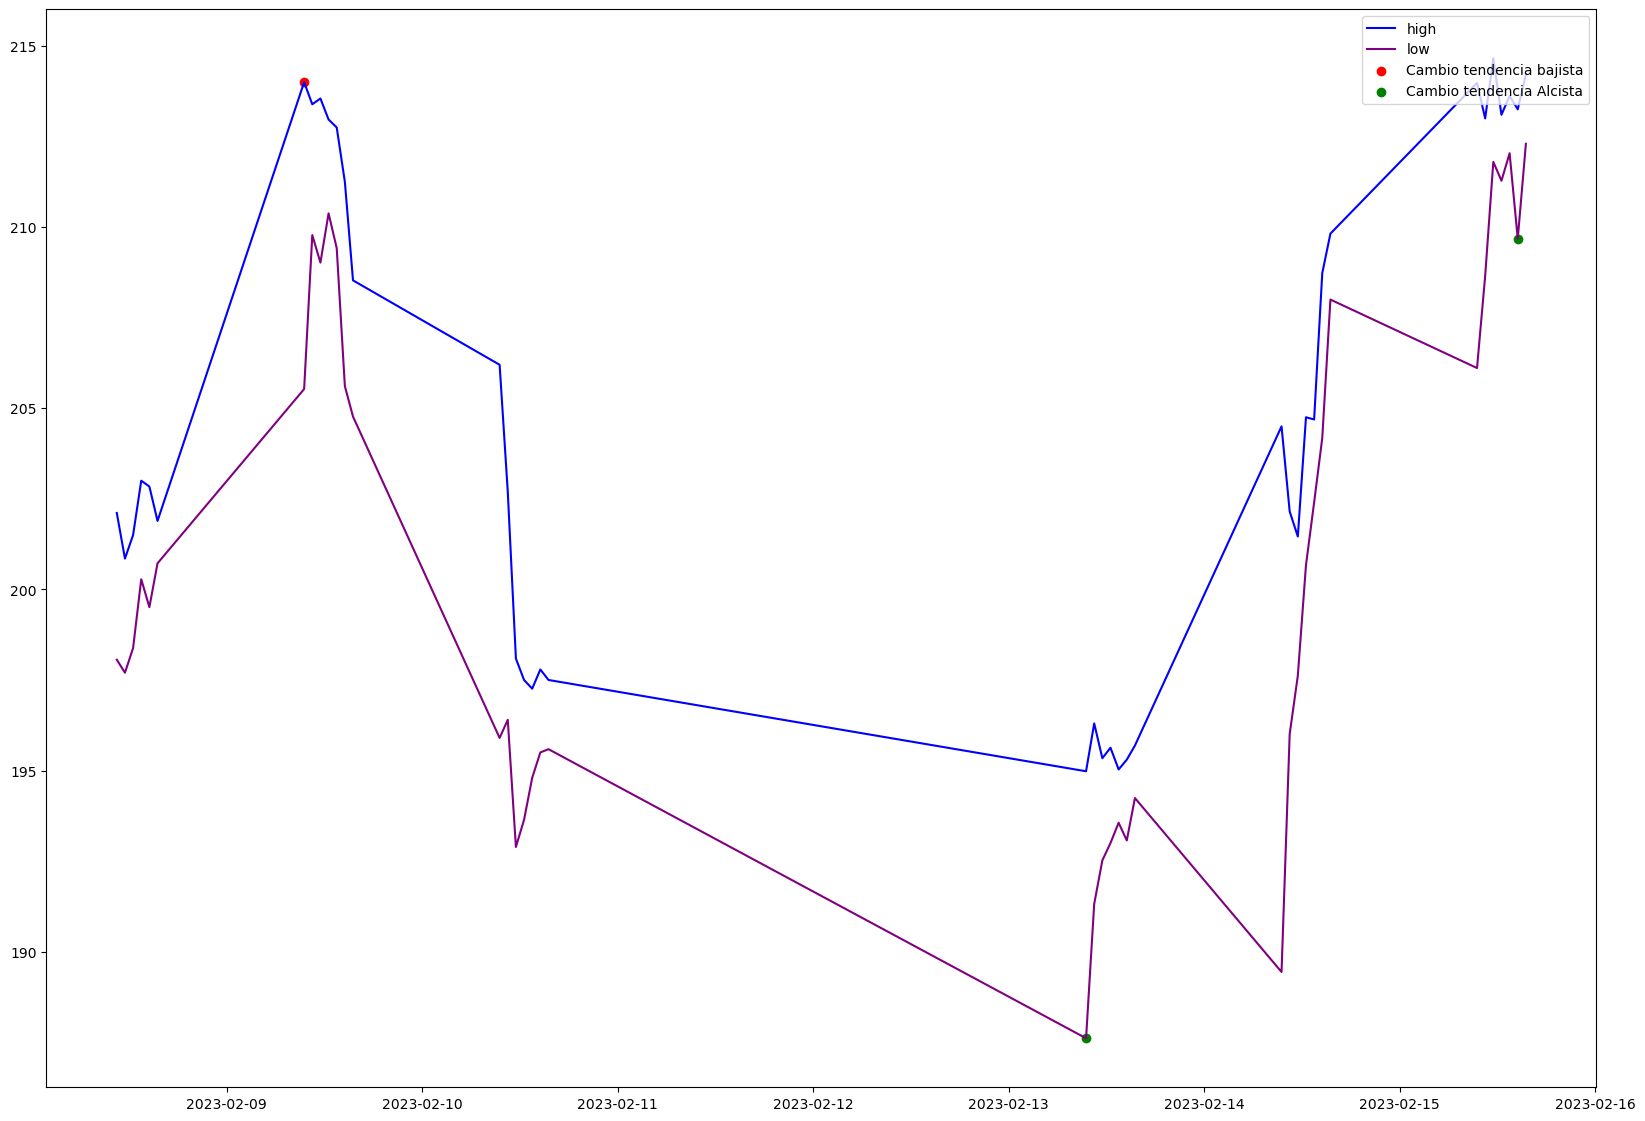

In [57]:
# grafico
fig = plt.figure(figsize=[20,14])
ax = fig.add_subplot(111)
#plt.subplot(121)
#plt.plot(highslows, color='green', label = 'close')
#plt.subplot(122)
plt.plot(df_h3.query("companyName=='TSLA' and id_posiblepm40==1")['datetime'], df_h3.query("companyName=='TSLA' and id_posiblepm40==1")['high'], color='blue', label = 'high')
#plt.plot(df_h3.query("companyName=='TSLA' and id_posiblepm40==1")['datetime'], df_h3.query("companyName=='TSLA' and id_posiblepm40==1")['close'], color='blue', label = 'close')
plt.plot(df_h3.query("companyName=='TSLA' and id_posiblepm40==1")['datetime'], df_h3.query("companyName=='TSLA' and id_posiblepm40==1")['low'], color='purple', label = 'low')
ax.scatter(df_h3.query("companyName=='TSLA' and id_posiblepm40==1")['datetime'], df_h3.query("companyName=='TSLA' and id_posiblepm40==1")['trendhigher'], color='red', label = 'Cambio tendencia bajista')
ax.scatter(df_h3.query("companyName=='TSLA' and id_posiblepm40==1")['datetime'], df_h3.query("companyName=='TSLA' and id_posiblepm40==1")['trendlower'], color='green', label = 'Cambio tendencia Alcista')
plt.legend(loc="upper right")

In [59]:
top_valuesxcasos['ind_high'] = top_valuesxcasos['high'] 

In [61]:
top_valuesxcasos.query("companyName=='TSLA'")

,open,high,low,close,adj close,volume,date,datetime,companyName,SMA20,...,SMA100,SMA200,trendlower,trendhigher,pm40_01,ind_SMA,id_posiblepm40,ind_posicion,iniTrendLow,ind_high
0,207.774994,214.000000,205.530106,211.110107,211.110107,69439719,2023-02-09,2023-02-09 09:30:00,TSLA,197.317566,...,170.422381,144.855409,NaN,214.000000,0,1,1.0,-2,True,214.000000
1,210.514999,213.550003,209.020004,212.794998,212.794998,25060327,2023-02-09,2023-02-09 11:30:00,TSLA,199.068336,...,172.073230,145.856056,NaN,NaN,0,1,1.0,-2,False,213.550003
2,211.089996,213.389999,209.780197,210.449997,210.449997,33376897,2023-02-09,2023-02-09 10:30:00,TSLA,198.132586,...,171.255280,145.347359,NaN,NaN,0,1,1.0,-2,False,213.389999
3,214.940002,217.649994,214.470001,216.255005,216.255005,31542877,2023-02-16,2023-02-16 10:30:00,TSLA,206.196815,...,192.204826,160.940376,NaN,217.649994,0,1,2.0,-1,True,217.649994
4,216.279999,216.937607,214.039993,215.710205,215.710205,17276832,2023-02-16,2023-02-16 11:30:00,TSLA,207.244576,...,192.705727,161.465976,NaN,NaN,0,1,2.0,-1,False,216.937607
5,215.729996,216.800003,209.740005,210.755997,210.755997,34006379,2023-02-16,2023-02-16 12:30:00,TSLA,208.073650,...,193.117941,161.967906,NaN,NaN,0,1,2.0,-1,False,216.800003
6,191.679993,192.960007,190.630005,191.210007,191.210007,24337794,2023-05-23,2023-05-23 10:30:00,TSLA,182.532391,...,171.141849,170.439162,NaN,192.960007,0,1,3.0,-1,True,192.960007
7,191.220001,191.240005,187.929993,188.009995,188.009995,19716349,2023-05-23,2023-05-23 11:30:00,TSLA,183.176441,...,171.382659,170.474762,NaN,NaN,0,1,3.0,-1,False,191.240005
8,188.009995,189.189896,186.199997,187.509995,187.509995,23714944,2023-05-23,2023-05-23 12:30:00,TSLA,183.807941,...,171.627486,170.509562,NaN,NaN,0,1,3.0,-1,False,189.189896
9,275.130005,276.989990,265.109985,267.788696,267.788696,63355834,2023-06-21,2023-06-21 09:30:00,TSLA,262.877925,...,236.403753,207.409200,NaN,276.989990,0,1,4.0,-1,True,276.989990


In [63]:
df_h4 = pd.merge(df_h3, top_valuesxcasos[['datetime','companyName', 'id_posiblepm40', 'ind_high', 'iniTrendLow']], on = ['companyName', 'id_posiblepm40','datetime'], how='left')

In [105]:
df_h4.query("companyName=='SPY' and id_posiblepm40==4 and ind_high>0")

,open,high,low,close,adj close,volume,date,datetime,companyName,SMA20,...,SMA100,SMA200,trendlower,trendhigher,pm40_01,ind_SMA,id_posiblepm40,ind_posicion,ind_high,iniTrendLow
135,407.045013,408.160004,406.920105,407.619995,407.619995,7328612,2023-01-27,2023-01-27 14:30:00,SPY,402.165875,...,396.091464,388.985154,NaN,408.160004,0,1,4.0,-1,408.160004,True
136,407.619995,407.885010,405.549988,405.679993,405.679993,12334964,2023-01-27,2023-01-27 15:30:00,SPY,402.707375,...,396.270764,389.064704,NaN,NaN,0,1,4.0,-1,407.885010,False
137,402.799988,405.130005,402.660004,403.899994,403.899994,13536129,2023-01-30,2023-01-30 09:30:00,SPY,403.097974,...,396.426064,389.142254,NaN,NaN,0,1,4.0,-1,405.130005,False


In [67]:
top_valuesxcasos.query("companyName=='TSLA' and id_posiblepm40==15")

,open,high,low,close,adj close,volume,date,datetime,companyName,SMA20,...,SMA100,SMA200,trendlower,trendhigher,pm40_01,ind_SMA,id_posiblepm40,ind_posicion,iniTrendLow,ind_high
41,184.667603,185.350006,183.835999,185.039993,185.039993,5674766,2024-06-18,2024-06-18 13:30:00,TSLA,182.925054,...,177.876392,176.785961,NaN,185.350006,0,1,15.0,-1,True,185.350006
42,184.679993,185.210007,180.720001,182.463196,182.463196,18894354,2024-06-20,2024-06-20 09:30:00,TSLA,183.466754,...,178.085183,176.926183,NaN,NaN,0,1,15.0,-1,False,185.210007
43,184.399994,185.100006,184.169998,184.880997,184.880997,3519355,2024-06-18,2024-06-18 15:30:00,TSLA,183.302094,...,178.036801,176.886259,NaN,NaN,0,1,15.0,-1,False,185.100006


In [69]:
#crea la linea trend solo con los 2 valores HIGH mas altos a partir del ultimo trendlower
def collect_channel(candle, backcandles, window, id_caso):
    #localdf = df_h4[candle-backcandles-window:candle-window]
    
    highs = dfpl[(dfpl['id_posiblepm40']==id_caso) & (dfpl['ind_high']>0)].high.values
    idxhighs = dfpl[(dfpl['id_posiblepm40']==id_caso) & (dfpl['ind_high']>0)].high.index

    if len(highs)>=2:
        sl_highs, interc_highs, r_value_h, _, _ = stats.linregress(idxhighs,highs)

        return(sl_highs, interc_highs, r_value_h**2)
    else:
        return(0,0,0)

In [71]:
#crea la linea trend con todos los datos HIGH a partir del ultimo trendlower
def collect_channel2(candle, backcandles, window, id_caso):
    #localdf = df_h4[candle-backcandles-window:candle-window]
    tupla = dfpl[['datetime', 'id_posiblepm40', 'iniTrendLow']].query("id_posiblepm40==@id_caso and iniTrendLow==True")
    fec = tupla['datetime'].iloc[0]
    print("fecha:", fec)
    
    highs = dfpl[(dfpl['id_posiblepm40']==id_caso) & (dfpl['datetime']>=fec) & (dfpl.index<=candle)].high.values
    idxhighs = dfpl[(dfpl['id_posiblepm40']==id_caso) & (dfpl['datetime']>=fec) & (dfpl.index<=candle)].high.index

    if len(highs)>=2:
        sl_highs, interc_highs, r_value_h, _, _ = stats.linregress(idxhighs,highs)

        return(sl_highs, interc_highs, r_value_h**2)
    else:
        return(0,0,0)

In [73]:
df_h4.query("companyName=='TSLA' and id_posiblepm40==15 and ind_high>0")

,open,high,low,close,adj close,volume,date,datetime,companyName,SMA20,...,SMA100,SMA200,trendlower,trendhigher,pm40_01,ind_SMA,id_posiblepm40,ind_posicion,ind_high,iniTrendLow
7890,184.667603,185.350006,183.835999,185.039993,185.039993,5674766,2024-06-18,2024-06-18 13:30:00,TSLA,182.925054,...,177.876392,176.785961,NaN,185.350006,0,1,15.0,-1,185.350006,True
7892,184.399994,185.100006,184.169998,184.880997,184.880997,3519355,2024-06-18,2024-06-18 15:30:00,TSLA,183.302094,...,178.036801,176.886259,NaN,NaN,0,1,15.0,-1,185.100006,False
7893,184.679993,185.210007,180.720001,182.463196,182.463196,18894354,2024-06-20,2024-06-20 09:30:00,TSLA,183.466754,...,178.085183,176.926183,NaN,NaN,0,1,15.0,-1,185.210007,False


In [75]:
df_h4.query("companyName=='TSLA' and id_posiblepm40==15")

,open,high,low,close,adj close,volume,date,datetime,companyName,SMA20,...,SMA100,SMA200,trendlower,trendhigher,pm40_01,ind_SMA,id_posiblepm40,ind_posicion,ind_high,iniTrendLow
7877,177.940002,178.750000,177.580002,178.639999,178.639999,6783180,2024-06-14,2024-06-14 14:30:00,TSLA,180.372624,...,176.835042,176.506956,NaN,NaN,0,1,15.0,-2,NaN,NaN
7878,178.630005,178.659897,177.779999,177.964996,177.964996,5476629,2024-06-14,2024-06-14 15:30:00,TSLA,180.476374,...,176.816692,176.482631,NaN,NaN,0,1,15.0,-2,NaN,NaN
7879,177.949997,182.289993,177.000000,181.967194,181.967194,23372206,2024-06-17,2024-06-17 09:30:00,TSLA,180.654234,...,176.841164,176.469817,NaN,NaN,0,1,15.0,-2,NaN,NaN
7880,181.970001,186.630005,181.910004,185.580002,185.580002,24402195,2024-06-17,2024-06-17 10:30:00,TSLA,180.986734,...,176.903564,176.471029,NaN,NaN,0,1,15.0,-2,NaN,NaN
7881,185.585007,187.158707,185.259995,186.167694,186.167694,12213924,2024-06-17,2024-06-17 11:30:00,TSLA,181.347118,...,177.009641,176.483667,NaN,NaN,0,1,15.0,-2,NaN,NaN
7882,186.179993,187.279999,184.449997,187.139893,187.139893,10756746,2024-06-17,2024-06-17 12:30:00,TSLA,181.687613,...,177.120140,176.494917,NaN,NaN,0,1,15.0,-2,NaN,NaN
7883,187.130005,188.809998,186.669998,187.100006,187.100006,12094372,2024-06-17,2024-06-17 13:30:00,TSLA,182.139864,...,177.218140,176.534592,NaN,188.809998,0,1,15.0,-2,NaN,NaN
7884,187.110001,188.550003,186.250000,188.419998,188.419998,10743366,2024-06-17,2024-06-17 14:30:00,TSLA,182.701363,...,177.342093,176.579142,NaN,NaN,0,1,15.0,-2,NaN,NaN
7885,188.419998,188.750000,187.300003,187.520004,187.520004,9455818,2024-06-17,2024-06-17 15:30:00,TSLA,182.824364,...,177.463843,176.618267,NaN,NaN,0,1,15.0,-2,NaN,NaN
7886,186.595001,187.199997,183.229996,183.473999,183.473999,25001940,2024-06-18,2024-06-18 09:30:00,TSLA,182.804564,...,177.535571,176.638637,NaN,NaN,0,1,15.0,-2,NaN,NaN


In [77]:
dfpl = df_h4.query("companyName=='TSLA' and id_posiblepm40==15 and trendlower>0 and ind_posicion==0")
dfpl

,open,high,low,close,adj close,volume,date,datetime,companyName,SMA20,...,SMA100,SMA200,trendlower,trendhigher,pm40_01,ind_SMA,id_posiblepm40,ind_posicion,ind_high,iniTrendLow
7897,180.199905,181.334702,179.669998,181.149994,181.149994,5274417,2024-06-20,2024-06-20 13:30:00,TSLA,184.030999,...,178.235383,177.065725,179.669998,NaN,1,1,15.0,0,NaN,NaN


In [79]:
symbol = 'TSLA'  # Puedes cambiar el símbolo según el activo que estés analizando
id_caso=15
dfpl = df_h4.query("companyName==@symbol and id_posiblepm40==@id_caso")
tupla = dfpl.query("ind_posicion==0")
candle = tupla.index[0]
backcandles = 20
window = 0
sl_highs, interc_highs,  r_sq_h = collect_channel(candle, backcandles, window, id_caso)

print("sl_highs:", sl_highs)
print("interc_highs:", interc_highs)
print("r_sq_h:", r_sq_h)

sl_highs: -0.057856968470982144
interc_highs: 641.8079158238003
r_sq_h: 0.4974949196132542


In [81]:
y=sl_highs*8322 + interc_highs
print("y:", y)

y: 160.32222420828685


In [83]:
 df_h4.query("companyName=='TSLA' and id_posiblepm40>0 and ind_posicion==0")

,open,high,low,close,adj close,volume,date,datetime,companyName,SMA20,...,SMA100,SMA200,trendlower,trendhigher,pm40_01,ind_SMA,id_posiblepm40,ind_posicion,ind_high,iniTrendLow
7323,194.414993,194.979996,187.610001,191.844498,191.844498,53966991,2023-02-13,2023-02-13 09:30:00,TSLA,202.217251,...,179.698654,150.663555,187.610001,NaN,1,1,1.0,0,NaN,NaN
7364,198.470001,202.850006,197.500000,200.856094,200.856094,29009574,2023-02-17,2023-02-17 11:30:00,TSLA,209.302025,...,194.671338,164.743588,197.500000,NaN,1,1,2.0,0,NaN,NaN
7405,182.229996,182.940002,178.220001,178.660004,178.660004,42319156,2023-05-24,2023-05-24 09:30:00,TSLA,184.974940,...,172.436717,170.485757,178.220001,NaN,1,1,3.0,0,NaN,NaN
7446,250.770004,261.700012,248.250000,261.575012,261.575012,57186742,2023-06-22,2023-06-22 09:30:00,TSLA,264.548653,...,240.852020,210.653287,248.250000,NaN,1,1,4.0,0,NaN,NaN
7487,259.290009,262.019989,252.800003,254.740005,254.740005,49167611,2023-06-23,2023-06-23 09:30:00,TSLA,264.410021,...,244.751585,213.892668,252.800003,NaN,1,1,5.0,0,262.019989,False
7528,270.045013,270.850006,265.100006,267.119995,267.119995,18872228,2023-07-10,2023-07-10 11:30:00,TSLA,276.543623,...,263.360830,243.551675,265.100006,NaN,1,1,6.0,0,NaN,NaN
7569,237.429993,237.500000,232.100006,234.190002,234.190002,35260133,2023-11-27,2023-11-27 09:30:00,TSLA,236.918961,...,227.811884,223.386010,232.100006,NaN,1,1,7.0,0,237.500000,False
7610,233.139999,236.330002,231.899994,233.255005,233.255005,37892650,2023-12-01,2023-12-01 09:30:00,TSLA,243.309466,...,234.026688,223.106346,231.899994,NaN,1,1,8.0,0,NaN,NaN
7651,248.580002,249.460007,247.000000,247.239899,247.239899,12048781,2023-12-20,2023-12-20 15:30:00,TSLA,254.846040,...,244.064906,238.729497,247.000000,NaN,1,1,9.0,0,NaN,NaN
7692,252.600006,252.710007,247.429993,248.020004,248.020004,21336449,2023-12-29,2023-12-29 10:30:00,TSLA,258.144554,...,250.176290,244.451834,247.429993,NaN,1,1,10.0,0,NaN,NaN


In [85]:
df_h4['id_posiblepm40'].max()

28.0

fecha: 2024-06-10 14:30:00


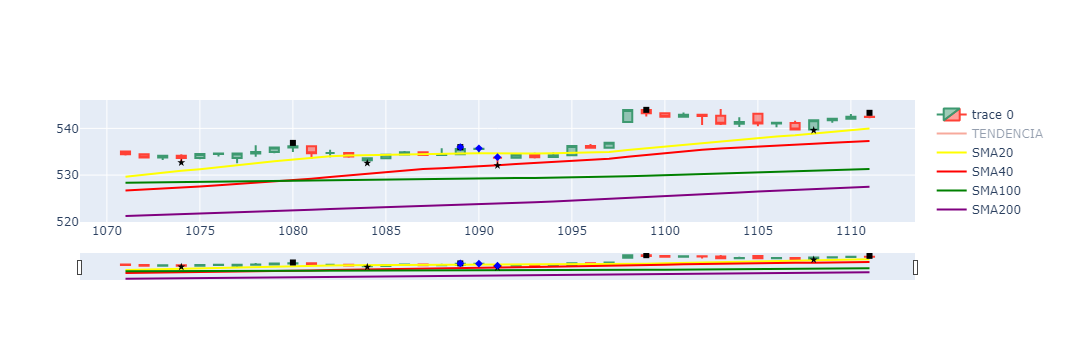

In [107]:
id_caso=27
symbol='SPY'

dfpl = df_h4.query("companyName==@symbol and id_posiblepm40==@id_caso")

fig = go.Figure(data=[go.Candlestick(x=dfpl.index,
                open=dfpl['open'],
                high=dfpl['high'],
                low=dfpl['low'],
                close=dfpl['close'])])

#company = df_casos['companyName'][i]
#tupla = dfpl[dfpl["ind_posicion"]==0]
tupla = dfpl.query("ind_posicion==0")
candle = tupla.index[0]
backcandles = 20
window = 0

sl_highs, interc_highs,  r_sq_h = collect_channel2(candle, backcandles, window, id_caso)
x = np.array(range(candle-backcandles-window, candle+5))
fig.add_trace(go.Scatter(x=x, y=sl_highs*x + interc_highs, mode='lines', name='TENDENCIA'))
fig.add_trace(go.Scatter(x=dfpl.index, y=dfpl["SMA20"], mode='lines', name='SMA20', line=dict(color="Yellow")))
fig.add_trace(go.Scatter(x=dfpl.index, y=dfpl["SMA40"], mode='lines', name='SMA40', line=dict(color="Red")))
fig.add_trace(go.Scatter(x=dfpl.index, y=dfpl["SMA100"], mode='lines', name='SMA100', line=dict(color="green")))
fig.add_trace(go.Scatter(x=dfpl.index, y=dfpl["SMA200"], mode='lines', name='SMA200', line=dict(color="purple")))
fig.add_trace(go.Scatter(x=dfpl.index, y=dfpl["trendhigher"], mode='markers', name='trendhigher', line=dict(color="black"), marker_symbol="square"))
fig.add_trace(go.Scatter(x=dfpl.index, y=dfpl["trendlower"], mode='markers', name='trendlower', line=dict(color="black"), marker_symbol="star" ))
fig.add_trace(go.Scatter(x=dfpl.index, y=dfpl["ind_high"], mode='markers', name='puntoTendencia', line=dict(color="blue"), marker_symbol="diamond" ))
#fig.add_trace(go.Scatter(df_h3.query("companyName=='AAPL' and id_posiblepm40==1")['datetime'], df_h3.query("companyName=='AAPL' and id_posiblepm40==1")['close_max'], color='red', label = 'Cambio tendencia bajista')
#fig = px.scatter(df, x="sepal_width", y="sepal_length", color="species")
#plt.plot(df_d2.query("companyName=='AAPL'")['date'], df_d2.query("companyName=='AAPL'")['SMA100'], color='red', label = 'SMA100')
#plt.plot(df_d2.query("companyName=='AAPL'")['date'], df_d2.query("companyName=='AAPL'")['SMA200'], color='green', label = 'SMA200')
fig.show()

In [89]:
dfpl

,open,high,low,close,adj close,volume,date,datetime,companyName,SMA20,...,SMA100,SMA200,trendlower,trendhigher,pm40_01,ind_SMA,id_posiblepm40,ind_posicion,ind_high,iniTrendLow
7467,262.440002,264.950012,261.899994,264.682587,264.682587,21789579,2023-06-20,2023-06-20 10:30:00,TSLA,258.555801,...,232.143747,204.345589,NaN,NaN,0,1,5.0,-2,NaN,NaN
7468,264.696594,268.970001,264.410004,268.749908,268.749908,19487382,2023-06-20,2023-06-20 11:30:00,TSLA,259.088046,...,232.829402,204.832049,NaN,NaN,0,1,5.0,-2,NaN,NaN
7469,268.760010,271.529907,267.859985,270.756104,270.756104,22537612,2023-06-20,2023-06-20 12:30:00,TSLA,259.971356,...,233.537363,205.326580,NaN,NaN,0,1,5.0,-2,NaN,NaN
7470,270.750000,271.510010,269.459991,271.299286,271.299286,18328329,2023-06-20,2023-06-20 13:30:00,TSLA,260.714821,...,234.255156,205.842776,NaN,NaN,0,1,5.0,-2,NaN,NaN
7471,271.299988,272.720001,270.029999,272.698395,272.698395,16591708,2023-06-20,2023-06-20 14:30:00,TSLA,261.511740,...,234.992740,206.368822,NaN,NaN,0,1,5.0,-2,NaN,NaN
7472,272.700012,274.750000,272.320007,274.459991,274.459991,15339809,2023-06-20,2023-06-20 15:30:00,TSLA,262.361990,...,235.736841,206.907906,NaN,NaN,0,1,5.0,-2,NaN,NaN
7473,275.130005,276.989990,265.109985,267.788696,267.788696,63355834,2023-06-21,2023-06-21 09:30:00,TSLA,262.877925,...,236.403753,207.409200,NaN,276.989990,0,1,5.0,-2,NaN,NaN
7474,267.750092,269.894409,260.140015,264.269989,264.269989,38460083,2023-06-21,2023-06-21 10:30:00,TSLA,263.360175,...,237.034553,207.889553,NaN,NaN,0,1,5.0,-2,NaN,NaN
7475,264.260010,266.279999,261.290009,261.903198,261.903198,24087677,2023-06-21,2023-06-21 11:30:00,TSLA,263.610834,...,237.679785,208.356669,NaN,NaN,0,1,5.0,-2,NaN,NaN
7476,261.885010,263.000000,257.779999,259.089996,259.089996,24049713,2023-06-21,2023-06-21 12:30:00,TSLA,263.757584,...,238.310735,208.806319,NaN,NaN,0,1,5.0,-2,NaN,NaN


In [91]:
df_h4.query("companyName=='TSLA' and id_posiblepm40==1 and ind_high>0")

,open,high,low,close,adj close,volume,date,datetime,companyName,SMA20,...,SMA100,SMA200,trendlower,trendhigher,pm40_01,ind_SMA,id_posiblepm40,ind_posicion,ind_high,iniTrendLow
7309,207.774994,214.000000,205.530106,211.110107,211.110107,69439719,2023-02-09,2023-02-09 09:30:00,TSLA,197.317566,...,170.422381,144.855409,NaN,214.0,0,1,1.0,-2,214.000000,True
7310,211.089996,213.389999,209.780197,210.449997,210.449997,33376897,2023-02-09,2023-02-09 10:30:00,TSLA,198.132586,...,171.255280,145.347359,NaN,NaN,0,1,1.0,-2,213.389999,False
7311,210.514999,213.550003,209.020004,212.794998,212.794998,25060327,2023-02-09,2023-02-09 11:30:00,TSLA,199.068336,...,172.073230,145.856056,NaN,NaN,0,1,1.0,-2,213.550003,False


In [93]:
import pandas as pd
import numpy as np
import yfinance as yf  # Asegúrate de tener instalada esta librería

# Descargar datos históricos
symbol = 'TSLA'  # Puedes cambiar el símbolo según el activo que estés analizando
data = yf.download(symbol, start='2023-01-01', end='2024-01-01')

# Calcular promedio móvil de 20 y 40
data['MA20'] = data['Close'].rolling(window=20).mean()
data['MA40'] = data['Close'].rolling(window=40).mean()

# Determinar tendencia alcista
data['TendenciaAlcista'] = np.where(data['MA20'] > data['MA40'], True, False)

# Identificar punto de quiebre
data['Quiebre'] = np.where(data['Low'] <= data['MA40'], True, False)

# Trasando la línea de tendencia bajista
data['TrendLine'] = data['High'].rolling(window=20).min()

# Señales de compra
data['Compra'] = np.where((data['TendenciaAlcista'] & (data['Close'] > data['TrendLine']) & (data['Close'].shift(1) <= data['TrendLine'].shift(1))), True, False)

# Señales de venta
data['Venta'] = np.where((data['Close'].shift(1) > data['Close']) & (data['Close'].shift(1) > data['Close'].shift(2)), True, False)

# Mostrar el dataframe con las señales
print(data[['Close', 'MA20', 'MA40', 'TendenciaAlcista', 'Quiebre', 'TrendLine', 'Compra', 'Venta']])

[*********************100%***********************]  1 of 1 completed

                 Close        MA20        MA40  TendenciaAlcista  Quiebre  \
Date                                                                        
2023-01-03  108.099998         NaN         NaN             False    False   
2023-01-04  113.639999         NaN         NaN             False    False   
2023-01-05  110.339996         NaN         NaN             False    False   
2023-01-06  113.059998         NaN         NaN             False    False   
2023-01-09  119.769997         NaN         NaN             False    False   
...                ...         ...         ...               ...      ...   
2023-12-22  252.539993  244.503500  233.655000              True    False   
2023-12-26  256.609985  245.529999  234.887749              True    False   
2023-12-27  261.440002  246.265999  236.489750              True    False   
2023-12-28  253.179993  246.717999  237.798249              True    False   
2023-12-29  248.479996  247.137998  238.868749              True    False   

In [95]:
data.query("Compra==True")

,Open,High,Low,Close,Adj Close,Volume,MA20,MA40,TendenciaAlcista,Quiebre,TrendLine,Compra,Venta
Date,,,,,,,,,,,,,
2023-03-03,194.800003,200.479996,192.880005,197.789993,197.789993,154193300,200.875500,171.234250,True,False,193.750000,True,False
2023-03-14,177.309998,183.800003,177.139999,183.259995,183.259995,143717900,195.172000,182.144750,True,True,177.350006,True,False
2023-07-28,259.859985,267.250000,258.230011,266.440002,266.440002,111446000,273.222500,259.264500,True,True,264.450012,True,False
2023-09-28,240.020004,247.550003,238.649994,246.380005,246.380005,117058900,257.360999,248.690499,True,True,245.330002,True,False
2023-12-13,234.190002,240.300003,228.199997,239.289993,239.289993,146286300,238.961500,227.493250,True,False,237.100006,True,False


In [97]:
# Cortar el DataFrame desde el índice 10 hasta el índice 20
df_cortado = data.loc['2023-02-01':'2023-03-07']

In [99]:
df_cortado

,Open,High,Low,Close,Adj Close,Volume,MA20,MA40,TendenciaAlcista,Quiebre,TrendLine,Compra,Venta
Date,,,,,,,,,,,,,
2023-02-01,173.889999,183.809998,169.929993,181.410004,181.410004,213806300,137.861499,NaN,False,False,111.750000,False,False
2023-02-02,187.330002,196.750000,182.610001,188.270004,188.270004,217448300,141.593000,NaN,False,False,111.750000,False,False
2023-02-03,183.949997,199.000000,183.690002,189.979996,189.979996,232662000,145.575000,NaN,False,False,114.389999,False,False
2023-02-06,193.009995,198.169998,189.919998,194.759995,194.759995,186188100,149.659999,NaN,False,False,122.629997,False,False
2023-02-07,196.429993,197.500000,189.550003,196.809998,196.809998,186010300,153.512000,NaN,False,False,122.629997,False,False
2023-02-08,196.100006,203.000000,194.309998,201.289993,201.289993,180673600,157.633999,NaN,False,False,122.629997,False,False
2023-02-09,207.779999,214.000000,204.770004,207.320007,207.320007,215431400,161.839000,NaN,False,False,122.629997,False,False
2023-02-10,202.229996,206.199997,192.889999,196.889999,196.889999,204754100,165.505500,NaN,False,False,122.629997,False,True
2023-02-13,194.419998,196.300003,187.610001,194.639999,194.639999,172475500,169.117500,NaN,False,False,129.990005,False,False


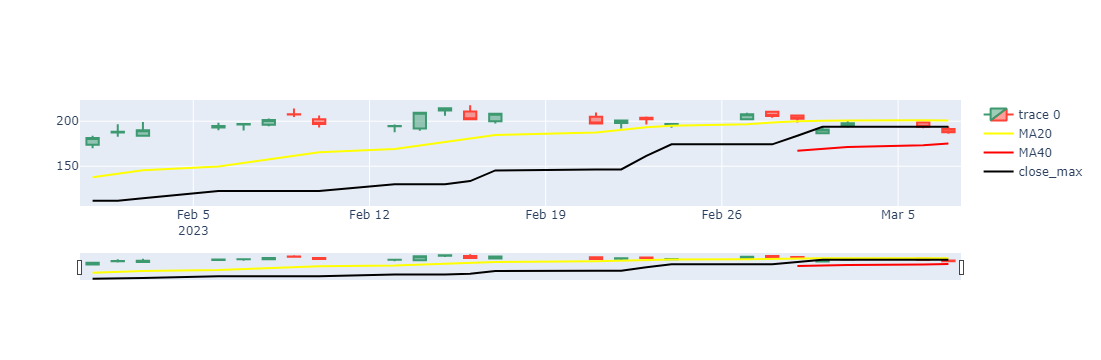

In [101]:
fig = go.Figure(data=[go.Candlestick(x=df_cortado.index,
                open=df_cortado['Open'],
                high=df_cortado['High'],
                low=df_cortado['Low'],
                close=df_cortado['Close'])])

#company = df_casos['companyName'][i]
#tupla = dfpl[dfpl["ind_posicion"]==0]
#tupla = dfpl.query("ind_posicion==0")
#candle = tupla.index[0]
#backcandles = 20
#window = 0

#sl_highs, interc_highs,  r_sq_h = collect_channel(candle, backcandles, window, id_caso)
#x = np.array(range(candle-backcandles-window, candle+1))
#fig.add_trace(go.Scatter(x=x, y=sl_highs*x + interc_highs, mode='lines', name='max slope'))
fig.add_trace(go.Scatter(x=df_cortado.index, y=df_cortado["MA20"], mode='lines', name='MA20', line=dict(color="Yellow")))
fig.add_trace(go.Scatter(x=df_cortado.index, y=df_cortado["MA40"], mode='lines', name='MA40', line=dict(color="Red")))
fig.add_trace(go.Scatter(x=df_cortado.index, y=df_cortado["TrendLine"], mode='lines', name='close_max', line=dict(color="black")))
#fig.add_trace(go.Scatter(x=dfpl.index, y=dfpl["close_min"], mode='markers', name='close_min', line=dict(color="black"), marker_symbol="star" ))
#fig.add_trace(go.Scatter(x=dfpl.index, y=dfpl["ind_high"], mode='markers', name='puntoTendencia', line=dict(color="blue"), marker_symbol="diamond" ))
fig.show()


In [103]:
#pd.unique(appl_hor3['id_posiblegpa'])
#specify path for export

import os
   
path = r'C:\Users\carlo\OneDrive\Documentos\TRADER\traderapp\data\pm40_h.txt'

# check whether the file exists
if os.path.exists(path):
    # delete the file
    os.remove(path)
else:
    # if the file does not exist.
    print("File does not exists. File needs to be created.")

#export DataFrame to text file
with open(path, 'a') as f:
    #df_string = appl_hor3.to_string(header=True, index=False, sep ='\t')
    df_h4.to_csv(path, header=True, index=None, sep='\t', mode='w')
    #f.write(df_string)